<a href="https://colab.research.google.com/github/Stephanie-DS/takehome-stephanie-workingcopy/blob/main/Reddit_code_challenge_Pulford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello, and welcome to my Pivotal Life Sciences code take home!
I'm Stephanie, a candidate for an AI-focused role on your team. My work over the last few years was to lead AI at a small chatbot company. If you've ever chatted with the NBA on Facebook, you've seen our work. :)

Of the three options for this challenge, the Reddit dataset challege seemed most interesting to me. It's probably not surprising that a person who works in chat AI enjoys finding patterns in online conversation. As I'll demonstrate in a brief coda to this notebook, the successful completion of this challenge relied on using very different techniques than the NLU AI I use on a daily basis and it was fun to have the chance to get out of my usual paradigm. Thank you for the opportunity!



# Overview and General Strategy
This challenge had two parts:


1.   To determine the attributes of a successful post on r/askscience
2.   To build a model that can predict the score of a post on r/askscience given at least the body and title.

These questions suggest a natural solution flow:
1. **Foundation:** Perform basic EDA toward understanding the dataset, operationalizing a metric for a "successful" post, and generating hypotheses.
2. **Hypotheses:** Generate and follow up on a series of hypotheses regarding which attributes are correlated with a successful post. Summarize these to complete the first part of the challenge.
3. **Model:** Build a regressor model to predict scores based on the post title and body. It is highly likely that the attributes found in the first two steps should inform the feature selection/engineering of this model.

Accordingly, this presentation notebook will follow that flow, with a bonus exploration folded in just for fun.

The work in this notebook is a summary, intended for human view. I have not included all of my exploratory work in this summary. A few of the cells in this notebook contain hard-coded results and parameters that were the result of e.g. lengthy tuning and evaluation loops that would be tedious to run interactively. I've included the full work files as supplemental notebooks in this PR so that you may follow up on my process at your leisure. Or you may discuss them with me directly, at spulford@gmail.com.

Let's begin:




# 1. Foundations: EDA and a definition of "success"

As a first step, I import the dataset and do some very basic EDA. An important feature of this dataset is that the 'body' field has many NA entries, as Reddit posts sometimes have no body content.

As a minor matter of data cleaning, I remove the [Meta] threads as outliers-- they're rare and have little to do with the subreddit itself.

In [2]:
# Obligatory library imports cell
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings("ignore") #Omitting warnings for easy reading.

# import data
url = 'https://raw.githubusercontent.com/Pivotal-Life-Sciences-DS/takehome-stephanie/main/askscience_data.csv'
df = pd.read_csv(url)
df = df[~df.tag.isin(['Meta', 'META'])] # Removing any Meta posts from this dataset.

In my EDA supplemental notebook, I construct a basic EDA dataframe to examine maxes, mins, means, modes, and any missing items. The 'body' field in particular has plenty of na's, but a quick check of reddit showed that this was because those were posts with titles but no body; they were legitimate posts and not outliers.

### Operationalizing "successful posts"
When we try to translate a qualitative concept to NLP data science, we often have to make some judgment calls. In this case, there's no strict criteria for 'success': is a successful post one that gets answered? Or one that engenders positive sentiments, or is upvoted, or provokes a volley of engaged replies?

In this case the relevant available data was restricted to scores and upvote ratio. After some thought I decided to base success on raw upvote score, and neglect ratio-- if a post had a high positive score, it could be considered successful, even if it had incurred controversy. (Besides, as the upvote ratios confirmed, askscience is a consistently constructive subreddit that does not invite nor reward trolling.)

Because there's no universal standard for how many upvotes indicate success, I decided to let the points distribution suggest success to me.

There is a natural "elbow" between the third and fourth quintile, that suggests that a natural break between unsuccessful and successful posts happen right around the start of the 60th percentile, around 1000 upvotes. **I have adopted 1000 upvotes as a soft definition of success**, though indeed most of the work I summarize simply follows the credo, "more upvotes is better".

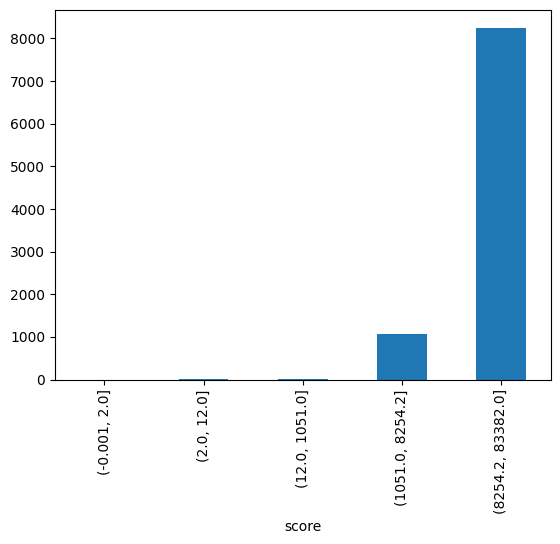

In [3]:
# Let's show a histogram of the scores in this dataset. Just the mins;
# though in my full EDA, the means follow suit.
scoresqfloor = df.groupby(pd.qcut(df.score, 5, duplicates="drop"))['score'].min().plot.bar()

### Preliminary Explorations
Does one ever really get through an NLP project without showing a wordcloud? As a quick means of seeing differences between sub-100 score unsuccessful posts and above-1000 score successful posts, I compared word clouds of both the titles and the bodies. The titles weren't interesting, but the bodies showed some key differences:


Text(0.5, 1.0, 'Score: Less than 1000')

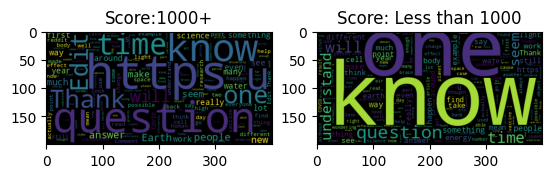

In [4]:
df['is_success'] = df['score']>=1000
df_success = df[df.is_success==True]
df_not_success = df[df.is_success==False]
success_body = ''.join(df_success['body'].fillna(" ").tolist())
success_title = ''.join(df_success['title'].fillna(" ").tolist())
not_success_body = ''.join(df_not_success['body'].fillna(" ").tolist())
not_success_title = ''.join(df_not_success['title'].fillna(" ").tolist())

wc_s = WordCloud().generate(success_body)
wc_n = WordCloud().generate(not_success_body)

plt.subplot(1, 2, 1)
plt.imshow(wc_s)
plt.title('Score:1000+')
plt.subplot(1, 2, 2)
plt.imshow(wc_n)
plt.title('Score: Less than 1000')

Many of the big words are the same, but a few key observations are that the "successful" cloud on the left contains "https", indicating that adding a link is correlated with success; and also prominently features "Thank" and "Edit", suggesting that conscientiousness is a factor in post success: thanking contributors, and providing responsive edits for clarity, updates, and other key developments.

There's a more analytic way to examine the word-content differences between different document classes: use their TF-IDF scores for a word matrix. TF-IDF, or 'term frequency, inverse document frequency' is a measure of how frequently a term is used in a given document, multiplied by the inverse of how frequently the term appears over a set of documents. If a word has a high TF-IDF for a given document or document class, that word's inclusion is a good feature to help distinguish one kind of document from another.

In the next cell I get TF-IDF scores for both "successful" and "unsuccessful" bodies. We'll use these later as a kind of feature, but for the moment we'll just consider their content.

In [5]:
#get TF-IDF for successful, unsuccessful post bodies
from sklearn.feature_extraction.text import TfidfVectorizer

# Here I am regarding a flat string of all successful bodies as if it is
# one document, and unsuccessful bodies as if they are a single document.
# This is a way to shorthand overall trends without setting up an
# analysis/classification of all individual posts.
corpus = [success_body,
          not_success_body]

df_corpus = pd.DataFrame({"texts": corpus})
# Set up a tf-idf vector, removing common English stopwords like 'the'
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# Fit the model to the texts
tfidf_separate = tfidf_vectorizer.fit_transform(df_corpus["texts"])

df_tfidf = pd.DataFrame(
    tfidf_separate.toarray(), columns=tfidf_vectorizer.get_feature_names_out(),
    index=df_corpus.index
)
# Now I get a dataframe. Indices are words;
# column 0 is TFIDF for successful posts, and col 1 is TFIDF for unsuccessful posts.
df_tf = df_tfidf.T

I'm interested in words that have the greatest tf-idf difference between successful and unsuccessful posts; so I take the difference between their tf-idf scores, and I rank them accordingly.

The top 20 terms that are unique to successful posts align with our observations in the word cloud. We see multiple politeness words like "thanks"; we see multiple words indicating links and references to other media; we see severak words like 'edit' and 'comments' that suggest thread engagement; and we see a set of words relating to research professionals and institutions, as proxies to appeals to ethos.

The bottom 20 terms is somewhat less interesting-- a few typos, indicating a lack of conscientiousness, and a handful of words that are likely to be used in a conversationally unspecific and ungenerous way: "**Does** anyone **know** why the sky is blue?"

There are also a handful of terms that deal with topics, but I found that topic analysis was covered well enough by the dataset's 'tags' field that I decided to trust the posts' tagging authors rather than commit a topic analysis de novo.

In [6]:
df_tf['dif'] = df_tf[0]-df_tf[1]
df_tf.sort_values('dif', ascending=False, inplace=True)

print("Successful posts: top terms")
print(df_tf.head(20))
print("Unsuccessful posts: terms")
print(df_tf.tail(20))

Successful posts: top terms
                   0         1       dif
edit        0.232971  0.056148  0.176823
https       0.281127  0.147388  0.133739
com         0.195227  0.103522  0.091705
www         0.190021  0.098843  0.091177
thank       0.100216  0.034507  0.065709
org         0.101518  0.038601  0.062916
http        0.101518  0.040356  0.061162
thanks      0.123644  0.064336  0.059308
cern        0.051218  0.000000  0.051218
answers     0.065076  0.018131  0.046945
university  0.050759  0.006434  0.044325
research    0.076789  0.033338  0.043452
news        0.057267  0.014622  0.042645
nasa        0.046854  0.008188  0.038666
science     0.089804  0.051469  0.038336
dr          0.045553  0.007603  0.037950
black       0.067679  0.032168  0.035511
earth       0.122342  0.087146  0.035196
comments    0.050759  0.017546  0.033213
twitter     0.039045  0.006434  0.032612
Unsuccessful posts: terms
                   0         1       dif
having      0.023427  0.049714 -0.026287
poi

## Hypotheses pursuit
Based partially on the EDA and partially on my own experiences with human conversational data on the web, I spent some time generating a short list of hypotheses to test toward finding attributes that correlated with post success.

Most of these were tested quickly and by visual inspection; they can be seen in succession in the EDA supplemental notebook. Some were de-prioritized because of interest and time. Here I'll summarize my findings, and show a few that are of interest.


**Hypotheses that were examined in the EDA file:**
*   **Title length correlates to success.** To my surprise, longer titles correlated with more successful posts; I'd suspected the opposite.
*  ** Body length correlates to success.** Again, against my assumptions, shorter body lengths were more successful. Many extremely successful posts had no body text at all, just a good title.
*  ** Tag correlates to success.** This was true; some tagged topics were extremely popular. Tags served as a proxy for major topics in this dataset.
*  ** Number of times an author posts correlates to success.** Except for a single high-posting outlier, it was true: repeat posting was associated with a single user's success rate. Was this correlation or causation? Beyond the scope of this project. :)
*   **It's an AMA or a Megathread:** Yes, these were extremely popular posts.
*   **The poster uses capitalization:** Yes, this correlated with a successful post, contributing to a general theme of conscientiousness.
*   Posts that include the word "school", indicating a follow up on school assignments or learnings, would be successful. Surprisingly, there were very few of these, so no signal.
*   Posts that included no question mark in their title, as a proxy for ill-formed questions, would not be successful. This result was confounded by the biggest non-question poster being the moderator, who often had wildly successful non-question posts such as AMAs.




**A few hypotheses that were de-prioritized for time:**
*   Different parts of speech, such as proper nouns, correlated with successful titles and bodies.
*   A positive sentiment, per a basic sentiment analysis, correlated with success.
*   Posting during weekday evenings in the United States correlated with success, because the thread would be visible during prime social media interaction hours.
*   Grammatical correctness and correct spelling, as a proxy for conscientiousness, correlated with success.


Though I looked at mean, median and sometimes mode for most of these issues, I prioritized median because it was a better visual description of the overall robustness of the effect.








<Axes: ylabel='tag'>

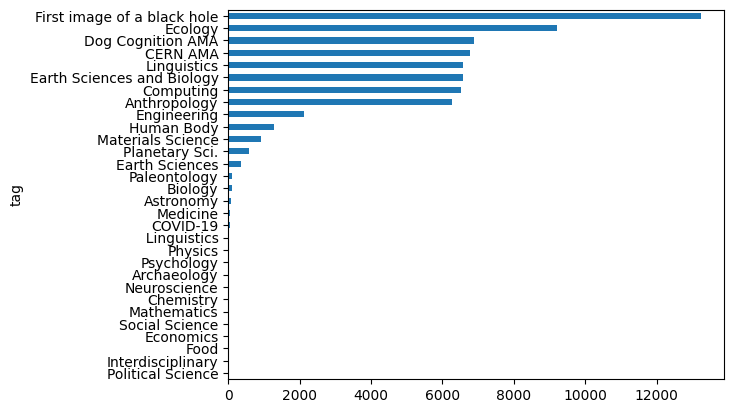

In [7]:
# Here's a plot of scores by tag.
# Can we really be surprised that the black hole image and dog cognition came
# out on top?

# Sad times for linguistics and mathematics, the backbone of this project.

tag_scores = df.groupby('tag')['score'].mean()
tag_scores_med = df.groupby('tag')['score'].median().sort_values(ascending=False)
df.groupby('tag')['score'].median().sort_values(ascending=True).plot.barh()

<Axes: ylabel='title_len'>

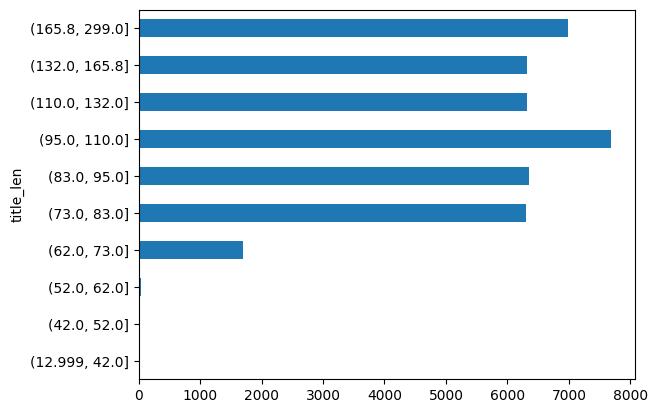

In [8]:
# Length of title
df['title_len'] = df['title'].str.len()
title_len_scores = df.groupby(pd.cut(df.title_len, 10))['score'].mean()
title_len_scores = df.groupby(pd.cut(df.title_len, 10))['score'].median()
df.groupby(pd.cut(df.title_len, 10))['score'].median().plot.barh()
title_check = df[df.title_len > 270]
title_check = df[(df.title_len < 270) & (df.title_len >241)]
df.groupby(pd.qcut(df.title_len, 10))['score'].median().plot.barh()

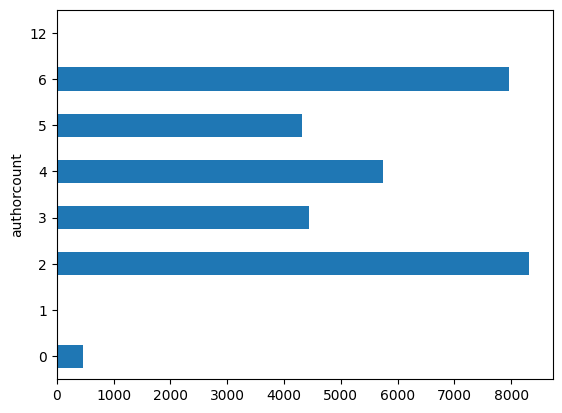

In [9]:
# author post count is significant, but has a nonlinear relationship with success
authorcount = df.groupby('author').size().sort_values(ascending=False)
authorcount = authorcount.to_frame(name='author_post_count')
authorcount.iloc[0]=0 # I want to remove counts for Deleted users
authorcount.iloc[1]=0 # i want to neutralize the mods' counts, too
df['authorcount'] = df['author'].replace(authorcount.index, authorcount['author_post_count'])
author_postcount_scores = df.groupby('authorcount')['score'].mean()
author_count_scores_med = df.groupby('authorcount')['score'].median().plot.barh()
#df_i = rawdf[df.author == 'inquilinekea'] # yeah it's this one outlier author

## Attributes that predict a successful post:

The data features that predict a successful post are included in the analysis and in the feature construction in the following section. For human readers, we might summarize the features of a successful post as follows:


*   Politeness - inclusion of thanks, etc
*   Conscientiousness - a capitalized and actively edited/interacted with post
*   Inclusion of a link
*   Words that imply ethos and background reading-- dr, university, research, news
*   Long titles
*   Shorter posts
*   Special posts like AMA and megathreads
*   Posting about subreddit favorite topic tags (some examples are current events like CERN or the black hole; dog cognition; ecology.)










# Building a Model To Predict Score

Based on the EDA and hypotheses of the last section, I created a basic featureset for this subreddit that would be discriminitive enough to predict scores.

### ML Methods
To predict a positive unbounded numerical score, even an integer score, suggests that a regressor model would be a better match to the task than a classifier.

Since no specific need except for prediction was indicated, I kept the default R^2 value for scoring and model optimization.

I started with a linear regression model and a ridge model, despite thinking they'd be a poor fit to the data, just to get a baseline linear model.

My key model is a random forest ensemble method. I chose this algorithm for a few reasons-- first, most importantly, it was much better than both a single tree regressor and all kernels of an SVC on my initial tests. Second, random forest performs well on multimodal and multiscale data; though I can normalize for SVC, it often doesn't perform well with unbounded data such as the scores.

Though tree methods can handle categorical data, I chose to use one-hot encoding on the tags just to ensure early compatibility across methods.



### Adding extra features to the df dataset:

In [75]:
# For simplicity, I am reconstructing the dataset here.
# I am adding a few features that were worthwhile from the previous
# section.

# I am adding a couple of features here to the dataframe that were significant,
# but don't seem worth a lot of tedious barplots.
# I'm adding them at this point because I intend to use them as features later.

# import data
url = 'https://raw.githubusercontent.com/Pivotal-Life-Sciences-DS/takehome-stephanie/main/askscience_data.csv'
df = pd.read_csv(url)
df = df[~df.tag.isin(['Meta', 'META'])] # Removing any Meta posts from this dataset.

df['authorcount'] = df['author'].replace(authorcount.index, authorcount['author_post_count'])
df['title_len'] = df['title'].str.len()
df['body_len'] = df['body'].str.len().fillna(0)
df['is_ama'] = df['title'].str.contains("AMA")
df['is_megathread'] = df['title'].str.contains("Megathread", case=False)
df['no_capitalization'] = df['title'].str.islower()

# adding tags as one-hot encoded columns
df = pd.get_dummies(df, columns=['tag'])


In [76]:
# For TF-idf features, I'm just going to compile the top and bottom 20
# temp: can make a feature

top_20 = list(df_tf.head(20).index.values)
bottom_20 = list(df_tf.tail(20).index.values)

has_top_20 =[]

for text in df.body.fillna(" "):
  contains=False
  for word in top_20:
    if word in text:
      contains=True
  has_top_20.append(contains)

#df['in_top_20'] = has_top_20

has_bottom_20 =[]

for text in df.body.fillna(" "):
  contains=False
  for word in bottom_20:
    if word in text:
      contains=True
  has_bottom_20.append(contains)

#df['in_bottom_20'] = has_bottom_20

In [77]:
df = df.drop(['title', 'body', 'datetime', 'author', 'upvote_ratio', 'url'], axis=1)

Index(['Unnamed: 0', 'score', 'authorcount', 'title_len', 'body_len', 'is_ama',
       'is_megathread', 'no_capitalization', 'tag_  Linguistics',
       'tag_Anthropology', 'tag_Archaeology', 'tag_Astronomy', 'tag_Biology',
       'tag_CERN AMA', 'tag_COVID-19', 'tag_Chemistry', 'tag_Computing',
       'tag_Dog Cognition AMA', 'tag_Earth Sciences',
       'tag_Earth Sciences and Biology', 'tag_Ecology', 'tag_Economics',
       'tag_Engineering', 'tag_First image of a black hole', 'tag_Food',
       'tag_Human Body', 'tag_Interdisciplinary', 'tag_Linguistics',
       'tag_Materials Science', 'tag_Mathematics', 'tag_Medicine',
       'tag_Neuroscience', 'tag_Paleontology', 'tag_Physics',
       'tag_Planetary Sci.', 'tag_Political Science', 'tag_Psychology',
       'tag_Social Science'],
      dtype='object')

Now that I have my featureset assembled in df, I'm going to do a basic linear regression first just to get some kind of baseline for this model.

In [78]:
X = df.drop('score', axis=1)
y = df['score']

# though it is best practice to use a validation set as well,
# for simplicity/time constraint I'm using a naive train/test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [79]:
# Getting a linear regression as a baseline. Abysmal!
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)

print("Training set score:, {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score:, {:.2f}".format(lr.score(X_test, y_test)))

Training set score:, 0.63
Test set score:, 0.66


In [80]:
# A ridge model, for some feature selection. Still terrible!
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)
print("Training set score:, {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score:, {:.2f}".format(ridge.score(X_test, y_test)))

Training set score:, 0.63
Test set score:, 0.66


We've looked at some linear models, and admittedly, they're pretty bad-- just .17 R^2 score. But given the nonlinear relationships of features to score, we think we can do better with nonlinear models.

I looked at several models in the supplmental file, and I found random forest to be a good match to this dataset. Here we're going to dive into tuning the hyperparameters of a random forest.

Note that I did not include n_estimators in the hyperparameter optimization-- more is always better, but I found in experiments that setting the estimators higher than the default of 100 made the optimization extremely lengthy with no real increase in prediction performance.


In [81]:

# Define hyperparameter search space
search_criterion = {
    'criterion':['squared_error'],
    'max_depth':[2,3,4,5,],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4]
}

In [82]:
from sklearn.ensemble import RandomForestRegressor
max_score = 0
best_parameters = {}

# Run grid search over hyperparameter space
for criterion in search_criterion['criterion']:
    for max_depth in search_criterion['max_depth']:
      for min_samples_split in search_criterion['min_samples_split']:
        for min_samples_leaf in search_criterion['min_samples_leaf']:
          rfr = RandomForestRegressor(
              criterion = criterion,
              max_depth = max_depth,
              min_samples_split = min_samples_split,
              min_samples_leaf = min_samples_leaf,
              random_state = 12,
          )

          rfr.fit(X_train, y_train)

          # Get a series of 5 cross validation scores for R^2
          myscore = rfr.score(X_test, y_test)


          # Compare mean balanced accuracy scores at the present parameter set
          # with the previous best set. If the current set outperforms
          # the prior winner, it becomes the new winner.
          if max_score < myscore:
            max_score = myscore
            best_parameters = {
                'criterion': criterion,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf
            }

In [84]:
best_parameters

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 4}

The optimization takes a while to run.
(On my home computer, this stripped down version takes 14mins! The original, with more criteria and variables, took over an hour. Oof.)

If you'd like to skip a step, here are the best parameters:

{'criterion': 'squared_error',
 'max_depth': 4,
 'min_samples_split': 2,
 'min_samples_leaf': 4}

The max R^2 score is .804.

I've hard coded these values into the next cell. If you've run the optimization grid search, simply skip the next cell; the results will be the same.

In [20]:
'''
best_parameters = {
                    'criterion': 'squared_error',
                    'max_depth': 4,
                    'min_samples_split': 2,
                    'min_samples_leaf': 4
                    }
'''


SyntaxError: invalid syntax (<ipython-input-20-ccf663cecbfb>, line 1)

In [85]:
# Use the best scores-- or the hard-coded version-- to run a single instace
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=0,
                            criterion=best_parameters['criterion'],
                            max_depth =best_parameters['max_depth'],
                            min_samples_split=best_parameters['min_samples_split'],
                            min_samples_leaf=best_parameters['min_samples_leaf']
                            )
rfr.fit(X_train, y_train)
print("Training set score:, {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score:, {:.2f}".format(rfr.score(X_test, y_test)))

Training set score:, 0.88
Test set score:, 0.88


Given a 5-fold cross validation, we might reasonably assume a (pre-production) R^2 around .88.

So, this model provides score predictions to .88 R^2 error, which (in my present work in web-based NLU) is a respectable score, especially for a simple time-limited first pass!

To increase this score, we'd consider:


*   Including part-of-speech information
*   Considering a DL model, perhaps in pytorch
*   Considering a topic-modeling approach or an entity-detection appraoch to posts, which are common for text-based regression but too complex for a short exploration
*   Layering as an ensemble with an embedding-model approach (see coda)

I'll note that I was surprised that this project didn't expressly demand a few standard techniques in NLP-related machine learning: I didn't use any techniques that demanded tokenization, lemmatization, or n-grams to process the text; nor did I use an ML model that required data normalization. In general these techniques might be considered part of general NLP/ML hygiene, but I happened to take a path that was not explicitly dependent on any of them being completed.






### Coda: transformer-model embeddings

This was a departure from my normal NLP AI work because it involved mostly pre-transformer language processing techniques. Working on natural language understanding AI on a chat bot, as I do, implies significant demand for generalization and automation-- and today, most paths toward this go through pre-trained transformer-based models such as BERT, LLama, Claude, and the OpenAI family.

A strength of these models is the ability to create an abstract, machine-learned vector 'embedding' of a text, which translates linguistic meaning into a spatial representation. Within this kind of representation, human grammatical/linguistic interpretation is not possible; instead, texts with similar meanings have high cosine similarity. These embedding models have particular strengths for language understanding because they are good at abstractly discerning similar meaning in lexically different texts.

For the sake of some John Henry good time, I pitted my feature-engineered model above against a mathematically abstract model that was based completely on openAI's embedding model. First I transformed all texts and bodies into embedded vectors, creating a feature set of 1538 * 2 features. I then used PCA to reduce the featureset to a subspace of 20-1000 dimensions, finding that 500 dimensions worked best for a tree ensemble method.

In this case, "best" was a relative statement-- even though this is a common AI approach, the best R^2 value I could get from this high-dimensional model was only an abysmal 0.30!

I invite you to examine the code, but caveat emptor regarding running the notebook. Getting the full embeddings takes a very long time-- and the API charges go to my personal credit card. XD

All in all, a nice example of a well-known aspect of machine learning-- the highest-tech, highest-dimension solution is not always the best solution to solve a given problem. We must always be ready to try a breadth of methods to find the best fit between problem, available data, and solution quality.

Thank you for hanging in there for so long. Best wishes, and I hope to hear from the Pivotal team soon.

-Stephanie Pulford